Статьи: 
1. https://qna.habr.com/q/1049696
2. https://stackoverflow.com/questions/7853628/how-do-i-find-an-image-contained-within-an-image
3. https://stackoverflow.com/questions/61067512/locating-a-picture-inside-a-bigger-picture
4. https://docs.opencv.org/3.4/de/da9/tutorial_template_matching.html
5. https://www.youtube.com/watch?v=vOJ6r0GVLPo

Идеи:
1) Back projection techique 
2) Использовать гистограммы, чтобы подобрать схожести в распределениях и накинуть треш холд для выявляения одной картинки на другой

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

В рамках данной задачи я столкнулся с сложностью мастаюирования реализованного решения для различных типов и форматов изображения и паттерна для мэтчинга. В зависимости от особенностей изображений (шум, количество схожих обьектов, размерность и тд) необходимо использовать разные способы. 

### Реализация решения №1 для простого случая
В рамках данной задачи, я решил сначала применить все имеющиеся классические (статистические) методы поиска паттернов одного изображения на другом. Чаще всего данные способы хорошо себя показывают, когда на изображении мало схожих между собой обьектов и малая зашумленность.

In [2]:
matching_methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

In [3]:
def mathch_object(matching_methods, main_pic, template_resized):
    h, w = template_resized.shape[:-1]
    
    for method in matching_methods:
        name = method
        main_copy = main_pic.copy()
        method = eval(method)
        result = cv2.matchTemplate(main_copy, template_resized, method)
        
        # bounding box
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
            
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(main_copy, top_left, bottom_right, (0, 255, 0), 10)
        
        plt.figure()
        plt.imshow(main_copy)
        plt.title(name)
        plt.show()
    
    

### Тест кейс 1

(1218, 1554, 3)


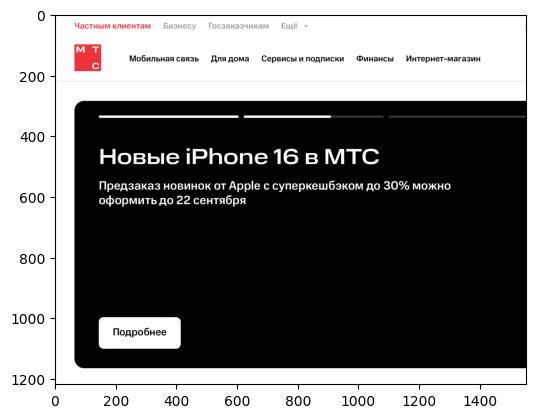

In [4]:
main_pic = cv2.imread('../images/mtc_main_page_simple.png')
main_pic = cv2.cvtColor(main_pic, cv2.COLOR_BGR2RGB)
plt.imshow(main_pic)
print(main_pic.shape)

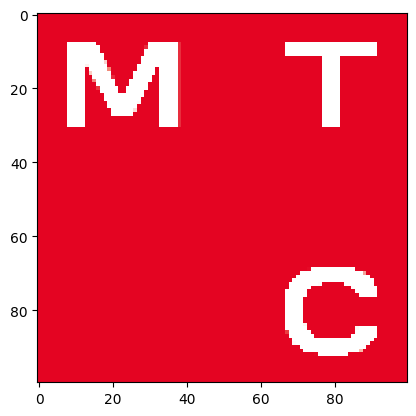

In [5]:
template = cv2.imread("../images/mts_logo_cmyk.png")
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template_resized = cv2.resize(template, (100, 100))
plt.imshow(template_resized)

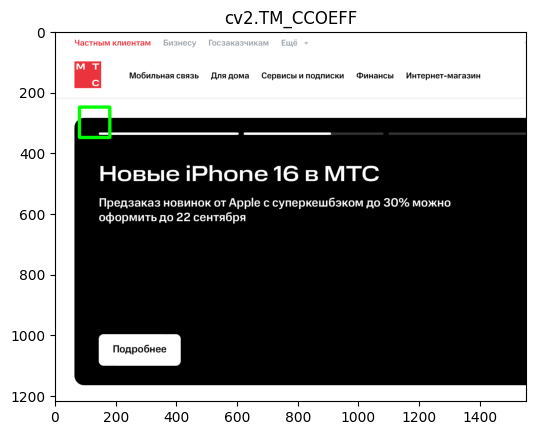

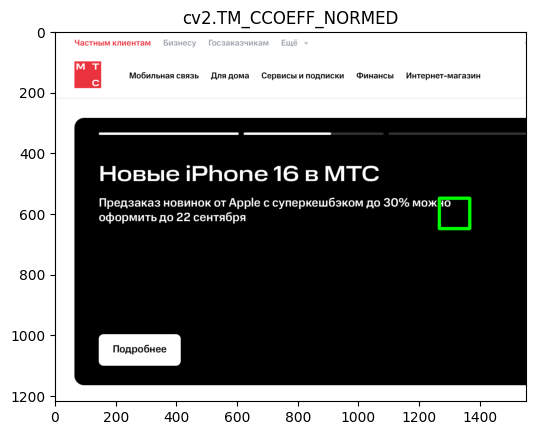

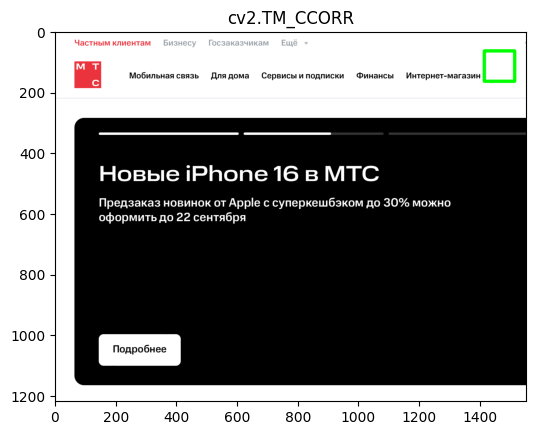

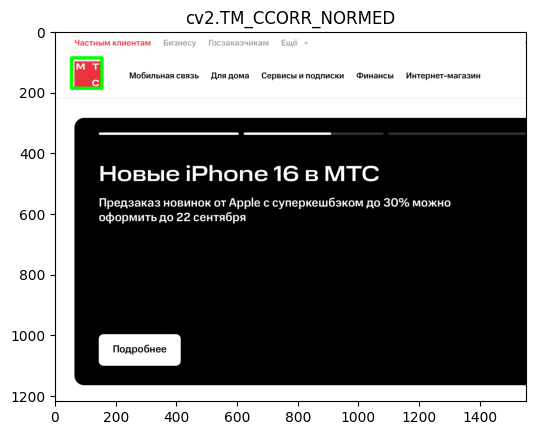

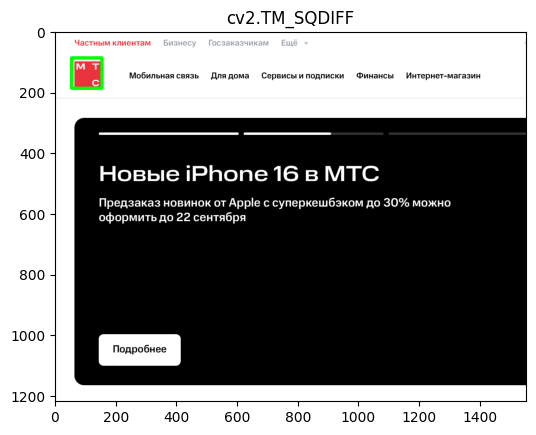

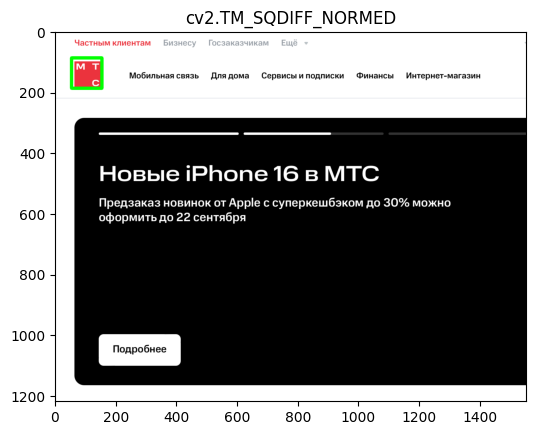

In [6]:
mathch_object(matching_methods, main_pic, template_resized)

### Тест кейс 2 (более сложный кейс с множеством отвлекающих обьектов)

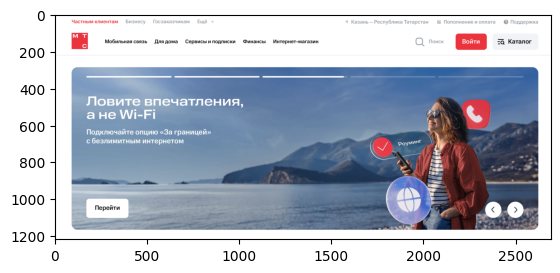

In [7]:
main_pic_2 = cv2.imread('../images/mtc_main_page.png')
main_pic_2 = cv2.cvtColor(main_pic_2, cv2.COLOR_BGR2RGB)
plt.imshow(main_pic_2)

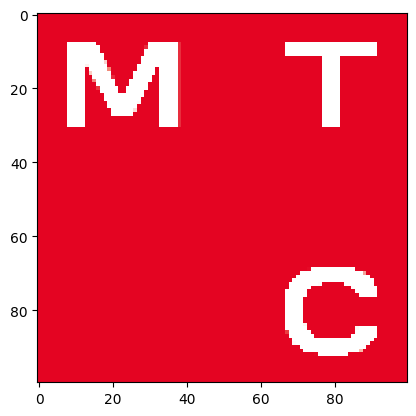

In [8]:
template_2 = cv2.imread("../images/mts_logo_cmyk.png")
template_2 = cv2.cvtColor(template_2, cv2.COLOR_BGR2RGB)
template_resized_2 = cv2.resize(template_2, (100, 100))
plt.imshow(template_resized_2)


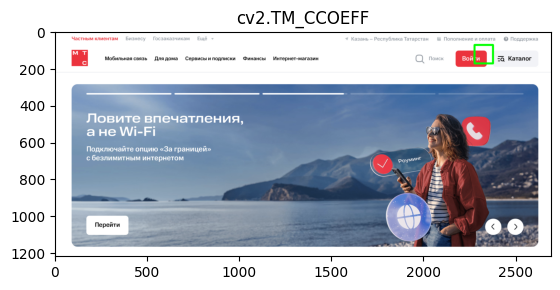

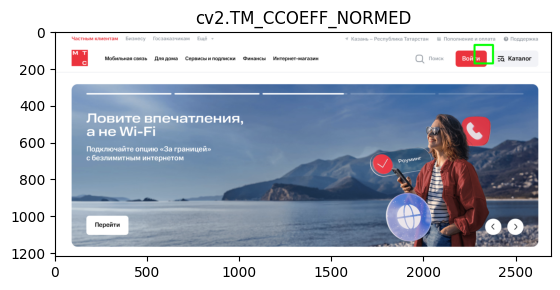

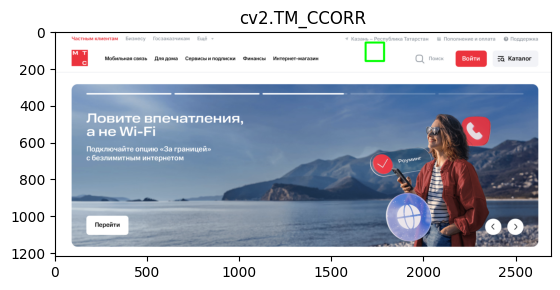

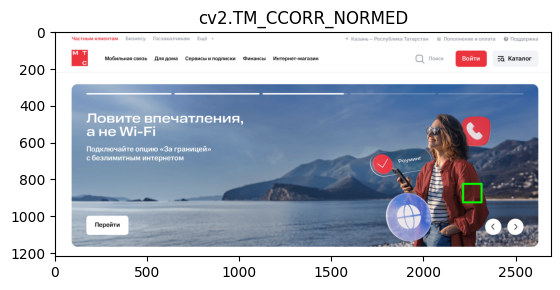

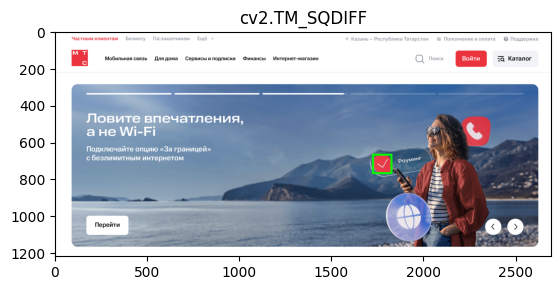

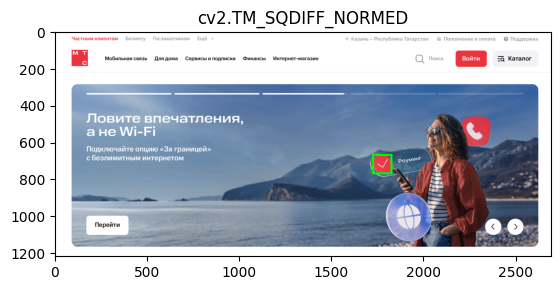

In [9]:
mathch_object(matching_methods, main_pic_2, template_resized_2)

Мы можем заметить, что когда на изображении появились схожие по размеру и цвету обьекты, то мы не смогли найти логотим МТС.

### Реализация решения №2 для более сложного случая

Принцип работы
Обнаружение ключевых точек: SIFT обнаруживает ключевые точки на обоих изображениях. Ключевые точки — это особые точки на изображении, которые легко распознать при различных условиях освещения и масштаба.

Вычисление дескрипторов: Для каждой ключевой точки вычисляется дескриптор — вектор, описывающий локальные особенности вокруг ключевой точки.

Сопоставление дескрипторов: FLANN используется для быстрого и эффективного сопоставления дескрипторов между двумя изображениями.

Фильтрация совпадений: Применяется тест Лоу для фильтрации ложных совпадений, оставляя только хорошие совпадения.

Замечания: данный способ необходимо модифицировать в зависимости от входных данных (подбирать коэффициеты ближайших соседей и менять способ поиска ключевых точек)

In [1]:
import cv2
import numpy as np

def detect_and_save(image_path, template_path, output_path):
    # Загрузка изображений
    source_image = cv2.imread(image_path)
    template_image = cv2.imread(template_path)

    # Конвертация изображений в оттенки серого
    source_gray = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)

    # Обнаружение объектов на изображении
    sift = cv2.SIFT_create()

    # Обнаружение ключевых точек и дескрипторов с помощью SIFT
    keypoints1, descriptors1 = sift.detectAndCompute(template_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(source_gray, None)

    # Матчинг дескрипторов с помощью FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Фильтрация совпадений
    good_matches = []
    for m, n in matches:
        if m.distance < 0.5 * n.distance:
            good_matches.append(m)

    # Поиск хомографичной матрицы
    if len(good_matches) > 4:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        h, w = template_gray.shape
        pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        source_image = cv2.polylines(source_image, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

    # Сохранить результат
    cv2.imwrite(output_path, source_image)


In [2]:
# Пример использования функции
detect_and_save('../images/mtc_main_page.png', '../images/mts_logo_cmyk.png', '../images/result.png')